In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

**Retrive data from Yahoo Finance API**

In [149]:
tick = yf.Ticker('TGTX')
d = tick.history(period="max", auto_adjust=False, actions=False)
d

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-05-03 00:00:00-04:00,205.312500,225.000000,196.875000,225.000000,225.000000,23
2010-05-04 00:00:00-04:00,210.937500,233.437500,196.875000,233.437500,233.437500,58
2010-05-05 00:00:00-04:00,233.437500,233.437500,196.875000,233.437500,233.437500,11
2010-05-06 00:00:00-04:00,225.000000,233.437500,225.000000,233.437500,233.437500,45
2010-05-07 00:00:00-04:00,196.875000,196.875000,196.875000,196.875000,196.875000,13
...,...,...,...,...,...,...
2024-06-14 00:00:00-04:00,16.639999,16.969999,16.235001,16.549999,16.549999,1906300
2024-06-17 00:00:00-04:00,16.459999,16.730000,16.211000,16.570000,16.570000,1577300
2024-06-18 00:00:00-04:00,16.709999,16.959999,16.389999,16.770000,16.770000,1534400


**Visualize Open Price**

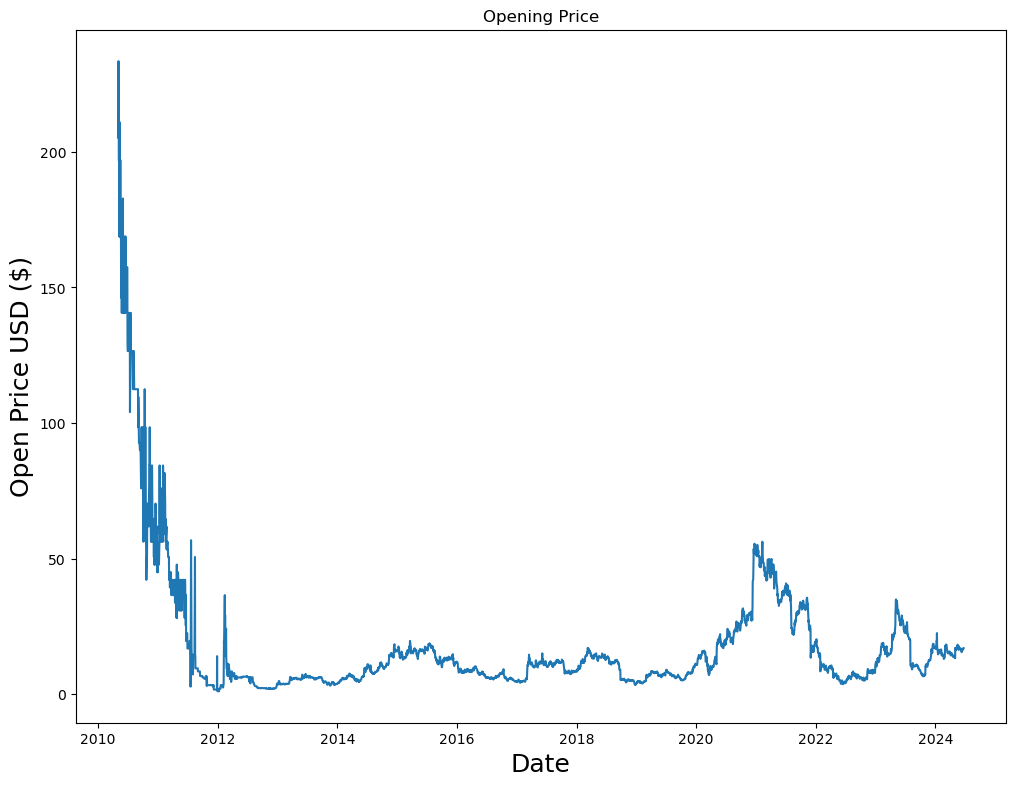

In [152]:
plt.figure(figsize=(12,9))
plt.title('Opening Price')
plt.plot(d['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

**Deep learning LSTM model using Univariate Time Series for predicting open price**

In [154]:
data = d.filter(['Open'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len,:]
X_train=[]
y_train=[]
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60 : i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1,epochs=3)
test_data=scaled_data[training_data_len-60: , : ]
X_test=[]
y_test=[]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(train_data[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred=model.predict(X_test)
pred=scaler.inverse_transform(pred)
rmse = np.sqrt(np.mean(pred-y_test)**2) 

Epoch 1/3
2788/2788 [==============================] - 53s 19ms/step - loss: 5.5054e-04
Epoch 2/3
2788/2788 [==============================] - 50s 18ms/step - loss: 3.5114e-04
Epoch 3/3
2788/2788 [==============================] - 49s 18ms/step - loss: 3.2173e-04


/var/folders/pm/t9dyphls4gjg80m3ff4xnnc40000gn/T/ipykernel_4449/2070978670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


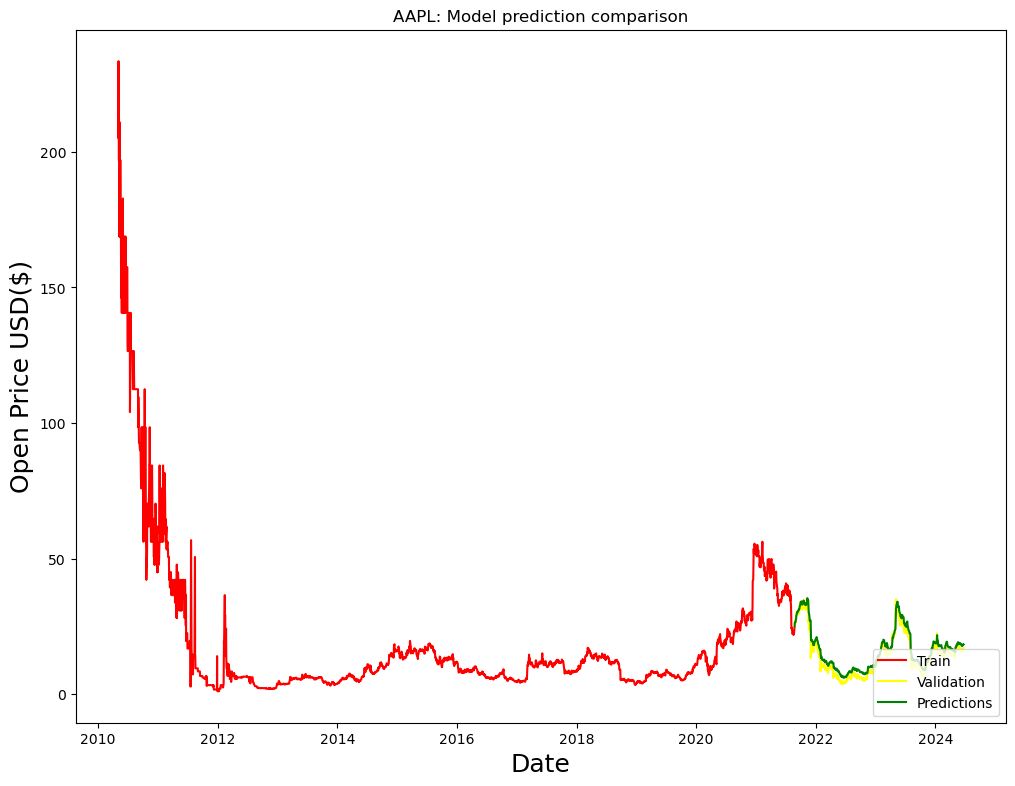

RMSE: 16.48381866104208


In [155]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = pred
plt.subplots(figsize=(12,9))
plt.title('AAPL: Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'], color='red')
plt.plot(valid['Open'], color='yellow')
plt.plot(valid['Predictions'], color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()
print(f'RMSE: {rmse}')

**Deep learning LSTM model using Univariate Time Series for predicting close price**

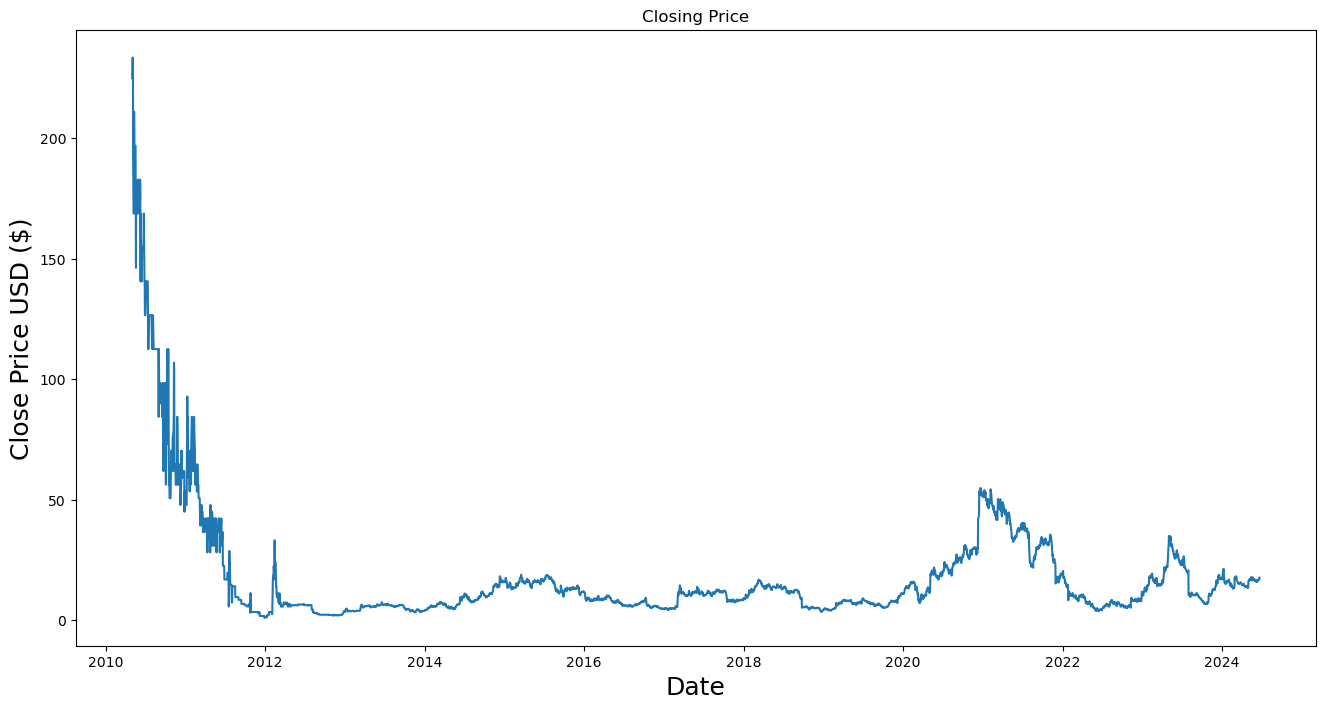

In [158]:
plt.figure(figsize=(16,8))
plt.title('Closing Price')
plt.plot(d['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [165]:
c_data = d.filter(['Close'])
c_dataset = c_data.values
c_data_len = math.ceil(len(c_dataset)*.8)
scaler2 = MinMaxScaler(feature_range=(0,1))
c_scaled_data = scaler2.fit_transform(c_dataset)
c_train_data = c_scaled_data[0:c_data_len,:]
c_X_train=[]
c_y_train=[]
for i in range(60, len(c_train_data)):
    c_X_train.append(c_train_data[i-60 : i, 0])
    c_y_train.append(c_train_data[i, 0])
c_X_train, c_y_train = np.array(c_X_train), np.array(c_y_train)
c_X_train = np.reshape(c_X_train, (c_X_train.shape[0], c_X_train.shape[1], 1))
model2=Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(c_X_train.shape[1],1)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(c_X_train, c_y_train, batch_size=1,epochs=3)
c_test_data = c_scaled_data[c_data_len-60: , : ]
c_X_test=[]
c_y_test=[]
for i in range(60, len(c_test_data)):
    c_X_test.append(c_test_data[i-60:i, 0])
    c_y_test.append(c_test_data[i,0])
c_X_test, c_y_test = np.array(c_X_test), np.array(c_y_test)
c_X_test=np.reshape(c_X_test,(c_X_test.shape[0], c_X_test.shape[1], 1))
c_pred=model.predict(c_X_test)
c_pred=scaler.inverse_transform(c_pred)
c_rmse = np.sqrt(np.mean(c_pred-c_y_test)**2) 

Epoch 1/3
2788/2788 [==============================] - 49s 17ms/step - loss: 7.1115e-04
Epoch 2/3
2788/2788 [==============================] - 48s 17ms/step - loss: 3.7481e-04
Epoch 3/3
2788/2788 [==============================] - 52s 19ms/step - loss: 3.7186e-04


/var/folders/pm/t9dyphls4gjg80m3ff4xnnc40000gn/T/ipykernel_4449/3245028593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_valid['Predictions'] = c_pred


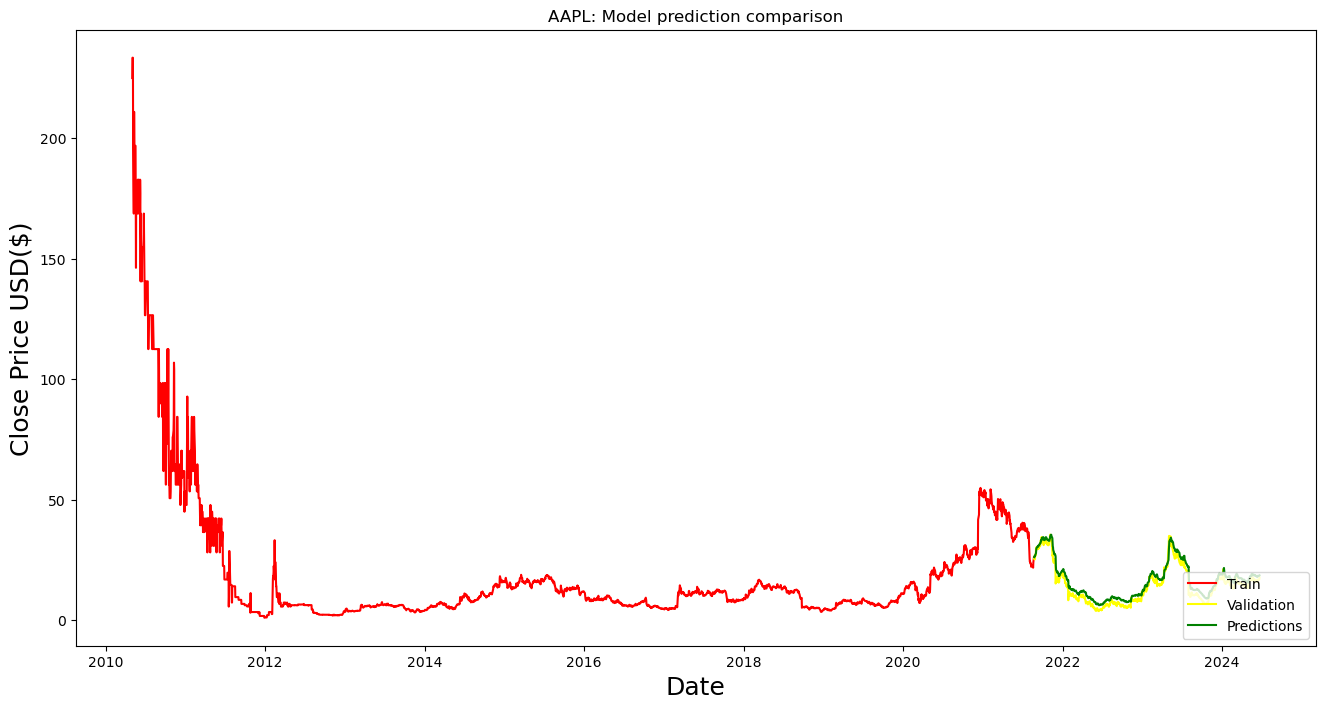

RMSE: 16.64019627074469


In [171]:
c_train = c_data[:training_data_len]
c_valid = c_data[training_data_len:]
c_valid['Predictions'] = c_pred
plt.figure(figsize=(16, 8))
plt.title('AAPL: Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(c_train['Close'], color='red')
plt.plot(c_valid['Close'], color='yellow')
plt.plot(c_valid['Predictions'], color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()
print( f'RMSE: {c_rmse}')